# Predicting the Helpfulness of Amazon Reviews
### Keane Johnson and Tucker Anderson

This notebook builds multiple models that predict the helpfulness of Amazon reviews. It uses the [2015 Amazon Review dataset](http://jmcauley.ucsd.edu/data/amazon/index.html), compiled by Julian McAuley, associate professor in the Computer Science department at the University of California, San Diego.

The dataset contains product reviews from Amazon from May 1996 - July 2014, and includes ratings, text, helpfulness votes, descriptions, category information, price, brand, and image features. It is broken into smaller subsets, organized by product category.

This notebook focuses on the Home and Kitchen sub-category, and uses the aforementioned features to predict helpfulness.

## Outline
- Import Libraries
- Load and Prepare Dataset
- Exploratory Data Analysis
- Model 1: Every review is 100% helpful
- Model 2: Naive Bayes Bag of Words with Binary Helpfulness Labels
- Model 3: TFIDF and Logistic Regression
- Model 4: BERT

## Import Libraries

In [53]:
# load packages
import gzip
import json
import os
import wget

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load and Prepare Dataset

In [54]:
# load dataset - download directly from source, save to data directory

file_name = "data/reviews_Home_and_Kitchen_5.json.gz"
output_dir = "data"
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz"

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

if not os.path.isfile(file_name):
    file_name = wget.download(url, out=output_dir)

In [55]:
# helper functions to parse data from compressed json into pandas DF
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def get_dataframe(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


# helper function to pull out total helpful votes
def get_helpful_votes(helpful):
    [helpful, total] = helpful
    return helpful


# helper function to pull out total votes (helpful and unhelpful)
def get_total_votes(helpful):
    [helpful, total] = helpful
    return total
    
    
# helper function to calculate helpfulness percentage 
def calculate_helpful_perc(helpful):
    [helpful, total] = helpful
    if total == 0:
        return 0
    else:
        return (helpful/total)

In [70]:
# create dataframe
df = get_dataframe(file_name)

# parse helpful column into new columns of helpful_votes, total_votes, helpful_perc
df['helpful_votes'] = df['helpful'].apply(get_helpful_votes)
df['total_votes'] = df['helpful'].apply(get_total_votes)
df['helpful_perc'] = df['helpful'].apply(calculate_helpful_perc)

## Exploratory Data Analysis

### Data Insights

In [71]:
df.shape

(551682, 12)

The dataset contains 551,682 rows and twelve columns.

In [72]:
df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,total_votes,helpful_perc
328060,A2NU9H8H5MJZSL,B002S0NJOO,Telstar,"[4, 5]",This weighs 8 pounds and is heavy and cumberso...,2.0,Different experience than most here,1285545600,"09 27, 2010",4,5,0.8
2114,A21HBURU1H6210,B00004OCJK,T. Tuttle,"[0, 2]",What can you say about a potato masher...It ma...,5.0,Reliable,1293926400,"01 2, 2011",0,2,0.0
549692,A2IKMRNKQ12ZPT,B00JR39AUM,"Amazon.Buyer ""Never argue with an 1d10t...the...","[0, 0]",Great set of cupcake liners. The assortment of...,5.0,Very cute cupcake molds,1405987200,"07 22, 2014",0,0,0.0
30521,A3G5MOHY1U635N,B00005N9DL,"A-mazon Customer ""SPB-RU""","[0, 0]",These are fun. They made of a heavier gauge s...,4.0,A cool garnishing tool,1245715200,"06 23, 2009",0,0,0.0
533328,A1PTK0BXOUEQXR,B00E1C1QNS,Minerva Cervantes,"[4, 5]",I am a finicky buyer and research everything p...,5.0,Despite the bad reviews I dared to buy it,1399766400,"05 11, 2014",4,5,0.8


The twelve columns contain data including the reviewer name and review time, in addition to more applicable data to our models, like review text, summary, and helpful scores. The helpful column is a list of two numbers. The first number is the number of individuals who found that review helpful. The second number is the total number of individuals who scored that review.

We parse out these two numbers in helpful_votes and total_votes. We calculate the helpfulness percentage as well in helpful_perc. This is simply the number of helpful_votes divided by the number of total_votes. Helpful_perc will be our target variable in our models.

There are two sources of natural language in the dataset - reviewText and summary. We assume the reviewText will be more robust and impactful in determining whether a review is helpful or not. However, summary is a good resource for our models as well.

Next, we want to examine the completeness of our dataset.

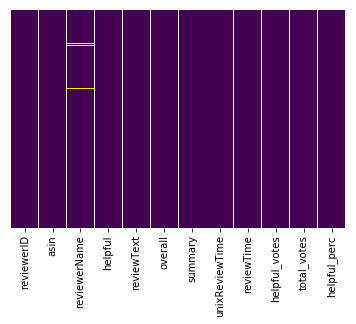

In [73]:
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

This heatmap shows that there are missing values for some observations of reviewerName. However, with such a large dataset, we could be missing some values for other features that just do not appear on this chart

In [74]:
missing_df = pd.DataFrame(df.isnull().sum())
missing_df

,0
reviewerID,0
asin,0
reviewerName,4953
helpful,0
reviewText,0
overall,0
summary,0
unixReviewTime,0
reviewTime,0
helpful_votes,0


We confirm that we are only missing values for reviewerName. We reason that this does not have an impact on our analysis because we will be using primarily the reviewText, and possibly the summary, to determine a review's helpfulness. Additionally, we argue that individuals do not consistently use a reviewer's name when determining a review's helpfulness.

### Summary Statistics

After reviewing some sample data, and examining missing values, we next look at some summary statistics of our dataset.

In [75]:
df.describe()

,overall,unixReviewTime,helpful_votes,total_votes,helpful_perc
count,551682.000000,5.516820e+05,551682.000000,551682.000000,551682.000000
mean,4.316655,1.348687e+09,3.497348,3.939469,0.367910
std,1.110749,6.120238e+07,76.539142,77.801556,0.456931
min,1.000000,9.572256e+08,0.000000,0.000000,0.000000
25%,4.000000,1.331770e+09,0.000000,0.000000,0.000000
50%,5.000000,1.367626e+09,0.000000,0.000000,0.000000
75%,5.000000,1.388880e+09,1.000000,2.000000,1.000000
max,5.000000,1.406074e+09,52176.000000,52861.000000,1.000000


These summary statistics show that over half of our observations have a 0% helpfulness. In addition, these observations have zero total votes. This means that the reviews simply haven't been voted upon. We should remove these observations from our dataset because our model could misinterpret the 0% helpful_perc to mean that the review was not helpful when in fact the review just hasn't been voted upon.

### Examining the Target Variable

We can use a histogram to visualize the distribution of helpful percentages.

Text(0.5,1,'Histogram of Helpful Percentages')

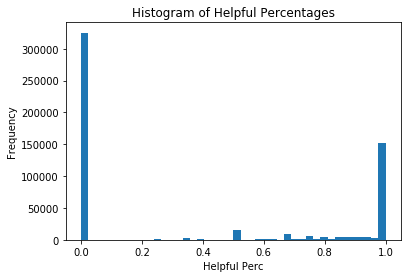

In [76]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
n, bins, patches = ax1.hist(x=df['helpful_perc'], bins='auto')
                                 
ax1.set_xlabel('Helpful Perc')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Helpful Percentages')

This histogram shows that the majority of reviews have a 0% helpful percentage, with the second most prevalent percentage being 100%. However, our dataset needs to be cleaned to remove observations that may add noise, but do not add meaning.

### Data Cleaning

We want to be purposeful with the data that we are supplying to our model. We want to only analyze reviews where there are at least three total votes, or reviews where there are two total votes, but both votes are in agreement.

Our rationale is that two total votes that are split does not tell us much. However, if both are an agreeement, that could tell us something about a reviews helpfulness.

In [77]:
# subset df of reviews that have at least three votes
df_three = df[df.total_votes >= 3]

# subset df of reviews that have two both and both are in agreeement
df_two = df[((df.total_votes == 2) & (df.helpful_perc == 1)) | ((df.total_votes == 2) & (df.helpful_perc == 0))]

# combine the dfs back together
df = df_three.append(df_two, ignore_index=True)
df.shape

(139470, 12)

The size of our dataset is now 139,470 rows. Next we can examine the new distribution of helpful_perc.

In [78]:
df.describe()

,overall,unixReviewTime,helpful_votes,total_votes,helpful_perc
count,139470.000000,1.394700e+05,139470.000000,139470.000000,139470.000000
mean,3.988270,1.301792e+09,13.178676,14.704022,0.848035
std,1.356746,8.137408e+07,151.811710,154.232187,0.242654
min,1.000000,9.572256e+08,0.000000,2.000000,0.000000
25%,3.000000,1.261181e+09,2.000000,3.000000,0.750000
50%,5.000000,1.324080e+09,4.000000,5.000000,1.000000
75%,5.000000,1.362874e+09,9.000000,10.000000,1.000000
max,5.000000,1.405728e+09,52176.000000,52861.000000,1.000000


The median helpful_perc is 100%. We could be at risk of not having a good distribution of data to train on. This could result in our model being overly optimistic and inflating the helpfulness scores of reviews. We can visualize this skew with another histogram.

Text(0.5,1,'Histogram of Helpful Percentages')

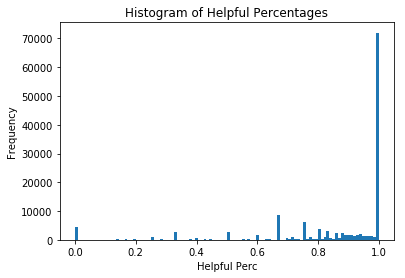

In [79]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
n, bins, patches = ax2.hist(x=df['helpful_perc'], bins='auto')
                                 
ax2.set_xlabel('Helpful Perc')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Helpful Percentages')

## Data Subsetting

Due to resource constraints, we'll subset our data to roughly half the original size. This is still more than enough data to build and test our models.

In [80]:
df_sampled = df.sample(80000)
df_sampled.shape

(80000, 12)

Text(0.5,1,'Histogram of Helpful Percentages of Subsetted Data')

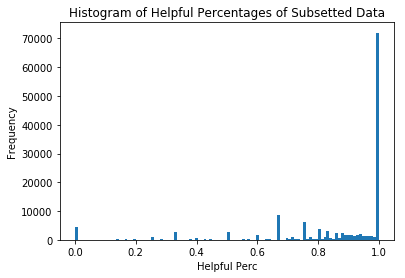

In [81]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(1, 1, 1)
n, bins, patches = ax3.hist(x=df['helpful_perc'], bins='auto')
                                 
ax3.set_xlabel('Helpful Perc')
ax3.set_ylabel('Frequency')
ax3.set_title('Histogram of Helpful Percentages of Subsetted Data')

The distribution of the sampled data visually matches the distribution of the original dataset. We can confirm the distributions are identical with the Kolmogorov-Smirnov statistic.

In [82]:
from scipy.stats import ks_2samp

df_sampled_helpful_prec = df_sampled['helpful_perc']
df_helpful_perc = df['helpful_perc']

ks_2samp(df_sampled_helpful_prec, df_helpful_perc)

Ks_2sampResult(statistic=0.0015600478597547762, pvalue=0.9996635655193835)

In [84]:
# df_sampled becomes our df
df = df_sampled

## Model 1: Every Review is Helpful

The most basic model we can produce is to label each review as being helpful if it meets a certain helpful_perc threshold. We choose 75%.

In [86]:
# calculate total number of reviews
total_reviews = len(df)

# calculate total number of reviews that are at least 75% helpful
helpful_reviews = len(df[df.helpful_perc >= 0.75])

# calculate accuracy if we predicted each review is at least 75% helpful
accuracy_1 = 100*(helpful_reviews/total_reviews)

print("Every Review is Helpful Accuracy Score -> ", accuracy_1)

Every Review is Helpful Accuracy Score ->  79.28


This model would produce an accuracy score of 79.3%.

## Model 2: Naive Bayes Bag of Words with Binary Helpfulness Labels

A more sophisticated model is one where we estimate the hepfulness of a review using its text. We use a Bag of Words model to determine whether a review is helpful or not. We again define a helpful review as one whose helpfulness percentage is at least 75%.

### Data Pre-Processing

In [87]:
import nltk
# this nltk download may be needed. download stopwords, punkt
# nltk.download()

In [88]:
# ensure there are no missing values in the review or summary text or the overall helpullness percentage
len(df) == len(df.dropna(subset=['reviewText', 'summary', 'helpful_perc']))

True

For our bag of words model, we will combine the reviewText and summary text fields to combine into a single "document" with which to analyze.

In [89]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 

stop_words = set(stopwords.words('english'))

def tokenize(text):
    return [word for word in word_tokenize(text) if not word in stop_words]

In [90]:
# We should then tokenize and stem the review data before ingesting into our NLP models
df['combinedText'] = df['summary'].str.lower() + ". " +  df['reviewText'].str.lower()

# Now tokenize these and remove stop words
df['processedText'] = df['combinedText'].apply(tokenize)

In [91]:
# Create new column for helpful reviews (reviews with at least a 75% helpfulness rating)

df["isHelpful"] = df["helpful_perc"] > .75
df["isHelpful"] = df["isHelpful"].apply(int)

In [92]:
#let's make sure everything looks ok
df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,total_votes,helpful_perc,combinedText,processedText,isHelpful
64197,A313H6238N589,B002AKKCLK,"Jaewoo Kim ""OB-Wan""","[2, 5]",BUNN makes coffee makers for most restaurants....,4.0,High quality construction; Denny's quality bla...,1294099200,"01 4, 2011",2,5,0.400000,high quality construction; denny's quality bla...,"[high, quality, construction, ;, denny, 's, qu...",0
31262,A2MTTIBDJHIRWW,B000BO58PC,Thomas Lundin,"[11, 13]","It's possible my unit was damaged in shipping,...",1.0,Build quality level: Asian novelty toy,1340755200,"06 27, 2012",11,13,0.846154,build quality level: asian novelty toy. it's p...,"[build, quality, level, :, asian, novelty, toy...",1
124747,A3R1PY4V3CQT20,B001DNTKUE,hickchick67,"[2, 2]",Got this to repair my Kitchen Aid pro series s...,4.0,as needed for repair,1342396800,"07 16, 2012",2,2,1.000000,as needed for repair. got this to repair my ki...,"[needed, repair, ., got, repair, kitchen, aid,...",1
53699,A1QOTVAQWR581Q,B0019KOFEC,Bonnie D. Pierce,"[4, 4]","Works great, easy set up, doesn't sound like a...",5.0,This vacuum sucks!,1271894400,"04 22, 2010",4,4,1.000000,"this vacuum sucks!. works great, easy set up, ...","[vacuum, sucks, !, ., works, great, ,, easy, s...",1
60335,A2X3L31KCXBHCL,B001P30HE0,"R. Song ""R. Song""","[18, 21]",THis container is exactly like the ones that c...,5.0,"Sturdy, air tight container",1287792000,"10 23, 2010",18,21,0.857143,"sturdy, air tight container. this container is...","[sturdy, ,, air, tight, container, ., containe...",1


Text(0.5,1,'Histogram of Helpful/Not Helpful Reviews')

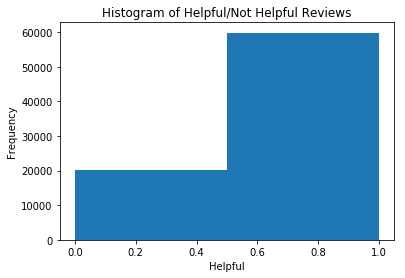

In [93]:
# take a look at distribution of Helpful/Not Helpful

fig4 = plt.figure()
ax4 = fig4.add_subplot(1, 1, 1)
n, bins, patches = ax4.hist(x=df['isHelpful'], bins=2)
                                 
ax4.set_xlabel('Helpful')
ax4.set_ylabel('Frequency')
ax4.set_title('Histogram of Helpful/Not Helpful Reviews')

In [94]:
from sklearn import preprocessing

data = df[['combinedText', 'isHelpful']]

le = preprocessing.LabelEncoder()
preprocessed_data = data.apply(le.fit_transform)

In [95]:
from sklearn.model_selection import train_test_split

Train_X, Test_X, Train_Y, Test_Y = train_test_split(preprocessed_data['combinedText'], 
                                                    preprocessed_data['isHelpful'],
                                                    test_size=0.2)

In [96]:
# and train our classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

g_classifier = GaussianNB().fit(np.array(Train_X.values.tolist()).reshape(-1, 1), Train_Y)
accuracy_2 = accuracy_score(Test_Y, g_classifier.predict(np.array(Test_X.values.tolist()).reshape(-1, 1)))*100

print("Gaussian Naive Bayes Accuracy Score -> ", accuracy_2)

Gaussian Naive Bayes Accuracy Score ->  75.26875


Our Naive Bayes Bag of Words model performs worse than our previous "every review is helpful" baseline model. It produces an accuracy score of 75.3%, down from 79.3%.

## Model 3: TF-IDF and Logistic Regression

In [97]:
# import packages
import sklearn
import string

from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression

In [98]:
# split into train/validation/test sets
data = df[['combinedText', 'isHelpful']]

df_train, df_test = train_test_split(data, test_size = 0.2)
df_train, df_val = train_test_split(df_train, test_size = 0.2)

In [99]:
# stem combinedText to reduce size of corpus
from nltk.stem import PorterStemmer

porter=PorterStemmer()

def stem_text(df):
    text_list = df['combinedText'].tolist()
    text_list_stem = [None] * len(text_list)

    for i in range(len(text_list)):
        text_list_stem[i] = ' '.join([porter.stem(w) for w in text_list[i].split()])
    
    return text_list_stem

text_list_stem = stem_text(data)

In [100]:
# vectorize text
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
                max_features=100,
                ngram_range=(1,1)
                )

vectorizer.fit_transform(text_list_stem).toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06767983, 0.07342374, 0.        , ..., 0.        , 0.04947998,
        0.        ],
       [0.        , 0.        , 0.14938476, ..., 0.07801581, 0.06045378,
        0.        ],
       ...,
       [0.        , 0.        , 0.1694486 , ..., 0.11799213, 0.09143108,
        0.        ],
       [0.        , 0.17308873, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.11253402, ..., 0.        , 0.27324501,
        0.        ]])

In [101]:
# vectorize train dataset
train_text_stem = stem_text(df_train)
train_vectorized = vectorizer.transform(train_text_stem).toarray()

print('Shape:', train_vectorized.shape)

Shape: (51200, 100)


In [102]:
# vectorize val dataset
val_text_stem = stem_text(df_val)
val_vectorized = vectorizer.transform(val_text_stem).toarray()

print('Shape:', val_vectorized.shape)

Shape: (12800, 100)


In [103]:
# vectorize test dataset
test_text_stem = stem_text(df_test)
test_vectorized = vectorizer.transform(test_text_stem).toarray()

print('Shape:', test_vectorized.shape)

Shape: (16000, 100)


In [104]:
# create array of labels to use in logistic regression
df_train_labels = np.array(df_train['isHelpful'])
df_test_labels = np.array(df_test['isHelpful'])
df_val_labels = np.array(df_val['isHelpful'])

In [105]:
# train logistic regression
lr = LogisticRegression(penalty='l2')
lr.fit(train_vectorized, df_train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [106]:
# tune hyperparameters
reg_str = [0.01, 0.1, 1.0, 10, 100, 1000]

best_acc = -1
best_c = None

for r in reg_str:
    lr = LogisticRegression(penalty='l2', C=r)
    lr.fit(train_vectorized, df_train_labels)
    preds = lr.predict(val_vectorized)
    acc = np.mean(preds == df_val_labels)
    print('regularization strength:', r, ' ', 'validation set accuracy:', acc)
    
    if acc > best_acc:
        best_acc = acc
        best_c = r

regularization strength: 0.01   validation set accuracy: 0.743828125
regularization strength: 0.1   validation set accuracy: 0.7453125
regularization strength: 1.0   validation set accuracy: 0.746484375
regularization strength: 10   validation set accuracy: 0.7465625
regularization strength: 100   validation set accuracy: 0.746328125
regularization strength: 1000   validation set accuracy: 0.74640625


In [107]:
# test accuracy
lr_final = LogisticRegression(penalty='l2', C = best_c)
lr_final.fit(train_vectorized, df_train_labels)

preds = lr_final.predict(test_vectorized)
accuracy_3 = 100*np.mean(preds == df_test_labels)

print("TF-IDF and Logistic Regression Accuracy Score ->", accuracy_3)

TF-IDF and Logistic Regression Accuracy Score -> 75.8125


The model with term frequency–inverse document frequency and logistic regression produces a marginally higher accuracy than the Naive Bayes Bag of Words model, but it is still not higher than the rudimentary Every Review is Helpful model. This motivates the need for a more robust representation of the language in the reviews. Enter BERT.

## Model 4: BERT